## Physics 4481-7681; CS 4812; AEP 4812-7681 ps5 problem 5


### due Wed 8 Nov 23:00 via gradescope

This is the last problem of ps5 -- the other problems are posted at [ps5.pdf](https://courses.cit.cornell.edu/physics4481-7681_2023fa/ps5.pdf) 

First, have a look through the [Qiskit chapter on Quantum Teleportation](https://learn.qiskit.org/course/ch-algorithms/quantum-teleportation/), including the part about [deferred measurements](https://learn.qiskit.org/course/ch-algorithms/quantum-teleportation/#deferred-measurement) (which will be used in the below to avoid confusions over Qiskit's classical condition `c_if`, which aren't implemented on real devices anyway).

The objective here will be to set up and execute the entanglement swapping depicted in Aaronson fig 10.3 (p. 73), as discussed in ps4#5 and lec 17:

In [3]:
from qiskit import IBMQ
from qiskit.compiler import transpile
IBMQ.load_account()
device_name = 'ibm_brisbane' 

ibmqfactory.load_account:WARNING:2023-12-10 23:59:12,711: Credentials are already in use. The existing account in the session will be replaced.


In [4]:
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main') # free account

backend = provider.backend.ibm_brisbane ## change this to preferred 7-qubit backend, depending on availability

## A.

First set up a Bell state between Alice and Charlie.

To be consistent with the conventions in [ps5#4](https://courses.cit.cornell.edu/physics4481-7681_2023fa/ps5.pdf), use the Bell state $|\psi_{11}\rangle = {1\over\sqrt2}\bigl(|01\rangle-|10\rangle\bigr)$ (also called $|\phi^-\rangle$). The first objective is to perform a set of measurements to confirm the state is entangled. As in ps5#4 (and explained in class), you will implement the "Entanglement Witness" $S$. This requires four different circuits, with either $I$ or $Y_{-\pi/2}$ applied to one qubit, and either $Y_{\pm \pi/4}$ applied to the other. It's sufficient in this case to set up a list of four circuits, and run 8192 shots of each.

**i)** First run the four circuits on the `qasm_simulator`, and calculate the $E = \langle Z Z\rangle$ values for the circuits individually, i.e., (# measurements same $-$ # measurements different) / #measurements, and then sum them (recalling that one of the four needs a $-$ sign as in ps5#4). Confirm that the result is less than the classical bound of $-2$. (It should be close to $-2\sqrt2$.)

**ii)** Run on one of the quantum computers (a 7-qubit machine is sufficient for this and part **B**).  Again check the value of the entanglement witness.

For consistency, use this initialization of your circuits:

{'11': 612, '01': 3447, '00': 549, '10': 3584}
8192
{'11': 559, '10': 3515, '00': 596, '01': 3522}
8192
{'01': 3540, '00': 626, '10': 3443, '11': 583}
8192
{'01': 572, '11': 3478, '10': 597, '00': 3545}
-8192
Expectation Values for the Circuits:
Expectation Value for Circuit 1: -0.716552734375
Expectation Value for Circuit 2: -0.718017578125
Expectation Value for Circuit 3: -0.704833984375
Expectation Value for Circuit 4: -0.714599609375
Entanglement Witnes S: -2.85400390625 as expected


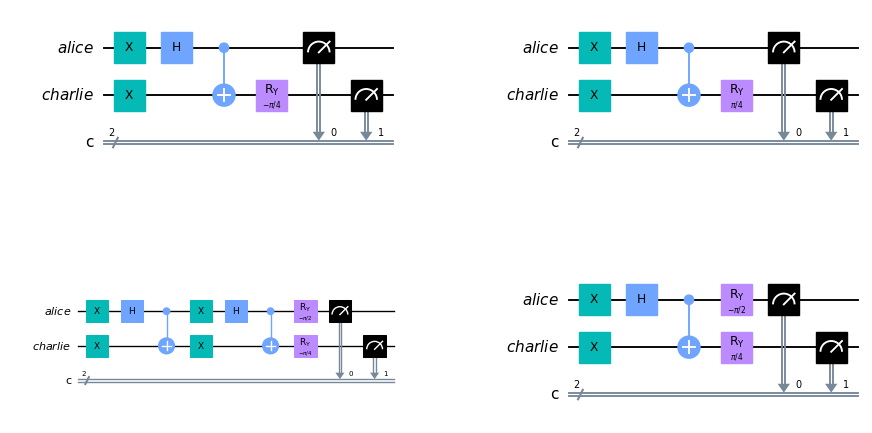

In [5]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import Aer, transpile, assemble, execute
import matplotlib.pyplot as plt
import numpy as np

qc_all = []
for i in range(1, 5):
    a = QuantumRegister(1, 'alice')
    c = QuantumRegister(1, 'charlie')
    m = ClassicalRegister(2, 'c')

    qc = QuantumCircuit(a, c, m)
    
    qc.x(0)
    qc.x(1)
    qc.h(0)
    qc.cx(0, 1)

    if i == 1:
        qc.ry(-np.pi/4, 1)
    elif i == 2:
        qc.ry(np.pi/4, 1)
    elif i == 3:
        qc.x(0)
        qc.x(1)
        qc.h(0)
        qc.cx(0, 1)
        qc.ry(-np.pi/2, 0)
        qc.ry(-np.pi/4, 1)
    elif i == 4:
        qc.ry(-np.pi/2, 0)
        qc.ry(np.pi/4, 1)

    qc.measure([0, 1], [0, 1])
    qc_all.append(qc)

simulator = True
if simulator:
    backend_sim = Aer.get_backend('qasm_simulator')
    fig,ax = plt.subplots(2,2, figsize=(11,6))
    for i in range(4): qc_all[i].draw('mpl', ax=ax.flatten()[i])
    job_sim = backend_sim.run(qc_all, shots=8192)
    result_sim = job_sim.result()
    counts = result_sim.get_counts()
else:
    backend = provider.backend.backends(device_name)[0]
    tags = ['GHZ_7']
    transpiled_circuits = transpile(qc_all, backend)
    transpiled_circuits[-2].draw('mpl') 
    job = backend.run(transpiled_circuits, job_tags=tags, shots=8192)
    counts = job.result().get_counts()
expectation_values = []

    

for i in range(len(counts)): 
    print(counts[i])
    same_counts = counts[i].get('00') + counts[i].get('11')
    different_counts = counts[i].get('10') + counts[i].get('01')
    total_counts = same_counts + different_counts
    if i == 3:
        total_counts = -1*total_counts
    
    print(total_counts)
    expectation = (same_counts - different_counts) / total_counts
    expectation_values.append(expectation)

total_expectation = sum(expectation_values)
print("Expectation Values for the Circuits:")
for i, exp_value in enumerate(expectation_values):
    print(f"Expectation Value for Circuit {i + 1}: {exp_value}")
print(f"Entanglement Witnes S: {total_expectation} as expected")

    



    




**iii)** You might wonder why Alice and Charlie can't infer they share qubits in state $|\psi_{11}\rangle$ by simply measuring and confirming that they always have different results, either $01$ or $10$. But this could also indicate a classical mixture: the state they're given to measure is $|01\rangle$ half the time, and $|10\rangle$ the other half, and never an entangled state. Calculate the value of the entanglement witness $S$ for this mixed state to see how it can be distinguished from the entangled state.

prepare state 1/rad(2)(|101> - |010>) and measure third qubit to prepare mixed state 1/2 |01> and 1/2 |10> and use this state to find S
{'000': 4109, '100': 4083}
{'000': 4123, '100': 4069}
{'001': 320, '110': 288, '000': 314, '010': 1746, '100': 1779, '101': 1693, '111': 311, '011': 1741}
{'110': 307, '100': 1741, '001': 294, '000': 315, '010': 1737, '111': 311, '011': 1771, '101': 1716}
Expectation Values for the Circuits:
Expectation Value for Circuit 1: 1.0
Expectation Value for Circuit 2: 1.0
Expectation Value for Circuit 3: 0.011962890625
Expectation Value for Circuit 4: -0.01025390625
Entanglement Witnes S: 2.001708984375
We have shown that the entanglement witness S for mixed state is different than entanngled


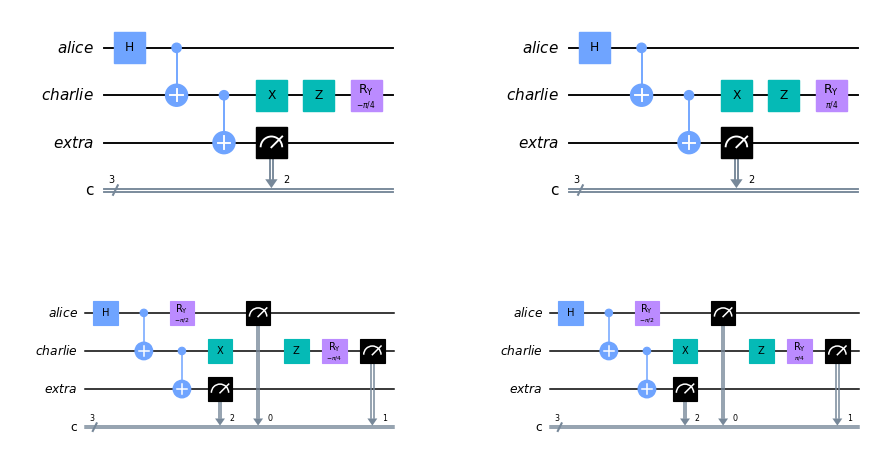

In [6]:
from qiskit.quantum_info import DensityMatrix

print('prepare state 1/rad(2)(|101> - |010>) and measure third qubit to prepare mixed state 1/2 |01> and 1/2 |10> and use this state to find S')

qc_all = []
for i in range(1, 5):
    a = QuantumRegister(1, 'alice')
    c = QuantumRegister(1, 'charlie')
    e = QuantumRegister(1, 'extra')
    m = ClassicalRegister(3, 'c')

    qc = QuantumCircuit(a, c, e, m)
    
    qc.h(0)
    qc.cx(0, 1)
    qc.cx(1, 2)
    qc.x(1)
    qc.z(1)
    qc.measure(2, 2)

    if i == 1:
        qc.ry(-np.pi/4, 1)
    elif i == 2:
        qc.ry(np.pi/4, 1)
    elif i == 3:
        qc.ry(-np.pi/2, 0)
        qc.ry(-np.pi/4, 1)
        qc.measure([0, 1], [0, 1])
    elif i == 4:
        qc.ry(-np.pi/2, 0)
        qc.ry(np.pi/4, 1)
        qc.measure([0, 1], [0, 1])

    qc_all.append(qc)

simulator = True
if simulator:
    backend_sim = Aer.get_backend('qasm_simulator')
    fig,ax = plt.subplots(2,2, figsize=(11,6))
    for i in range(4): qc_all[i].draw('mpl', ax=ax.flatten()[i])
    job_sim = backend_sim.run(qc_all, shots=8192)
    result_sim = job_sim.result()
    counts = result_sim.get_counts()
else:
    backend = provider.backend.backends(device_name)[0]
    tags = ['GHZ_7']
    transpiled_circuits = transpile(qc_all, backend)
    transpiled_circuits[-2].draw('mpl') 
    job = backend.run(transpiled_circuits, job_tags=tags, shots=8192)
    counts = job.result().get_counts()
expectation_values = []

def g_counts(counts,s):
    if counts.get(s) == None:
        return 0
    else:
        return counts.get(s)
    
for i in range(len(counts)): 
    print(counts[i])
    same_counts = g_counts(counts[i],'011') + g_counts(counts[i],'111') + g_counts(counts[i],'100') + g_counts(counts[i],'000')    
    different_counts = g_counts(counts[i],'010') + g_counts(counts[i],'001') + g_counts(counts[i],'110') + g_counts(counts[i],'101')   

    total_counts = same_counts + different_counts
    if i == 3:
        total_counts = -1*total_counts
    
    expectation = (same_counts - different_counts) / total_counts
    expectation_values.append(expectation)

total_expectation = sum(expectation_values)
print("Expectation Values for the Circuits:")
for i, exp_value in enumerate(expectation_values):
    print(f"Expectation Value for Circuit {i + 1}: {exp_value}")
print(f"Entanglement Witnes S: {total_expectation}")

print('We have shown that the entanglement witness S for mixed state is different than entanngled')



## B.

Now set up a circuit where Alice and Charlie continue to share two qubits in the $|\psi_{11}\rangle$ state, but as well Alice and Bob share two qubits in the $|\psi_{00}\rangle = {1\over\sqrt2}\bigl(|00\rangle+|11\rangle\bigr)$ (also called $|\psi^+\rangle$) state, as used in the teleportation protocol. Charlie and Diane also share two qubits in the $|\psi_{00}\rangle$ state, for a total of 6 qubits.  According to the figure above, Alice and Charlie each implement the teleportation protocol on the two qubits they hold, with the end result that Bob receives the entanglement state of Alice's original qubit, and Diane receives the entanglement state of Charlie's original qubit, so that Bob and Diane (who've never interacted) now in principle hold qubits in the Bell pair state $|\psi_{11}\rangle$.

(Alice's and Charlie's four qubits are now measured according to the protocol, and in principle they need to transmit the results of those measurements to Bob and Diane to apply appropriate $X$, $Z$ operators as final corrections, but in the below we'll use a workaround.)

The final step is to implement part **A** on the two qubits held by Bob and Diane, to confirm they're indeed in the $|\psi_{11}\rangle$ state. This will again involve creating four circuits with $I$,$Y_{-\pi/2}$ and $Y_{\pm \pi/4}$ applied to the last two qubits.

**i)** First run the four circuits on the `qasm_simulator`. The corrective $X$, $Z$ based on Alice's and Charlie's measurements could be applied via quantum control gates (as in Mermin figure 6.5f), but in order to reduce the number of gates, we'll instead use post-selection on the results. Show that if Alice's and Charlie's measurements are the same, then the $X$, $Z$ operators that would be applied by Bob and Diane have no net effect on their measurements.
Post-selection in this case means using only the roughly 25% of the data for which Alice's and Charlie's measurements agree, discarding the rest.

Using only the post-selected data, calculate the $E = \langle Z Z\rangle$ values for the circuits individually and use them to calculate $S$. Confirm that the result is less than the classical bound of $-2$. (It should again be close to $-2\sqrt2$.)

**ii)** Repeat on one of the quantum computers.

For this you might want to transpile in advance and use the `min_cx()` function defined part4 of the ps5_prob5_notes, to minimize the number of cNOT gates (I found that number to range between 6 and 20 for each circuit, so used the minimum of 6 for all four). 

For consistency, use this initialization of your circuits:

we add X and Z opertions to Bob and Diane's qubits to see if the 
final values change when Alice and Charlie measurements are the same.
Any combination of applying X's and Z's to Bob's and Diane's qubits
don't change S which means they have no net effect on their measurements

0: {'111111': 29, '001111': 33, '111010': 31, '101010': 225, '011111': 199, '100000': 232, '010101': 216, '110101': 33, '010000': 218, '001010': 39, '101111': 229, '011010': 185, '000101': 30, '000000': 38, '100101': 225, '110000': 36}
1: {'001111': 26, '011111': 228, '111111': 31, '100101': 205, '011010': 238, '010000': 243, '100000': 234, '110101': 32, '101010': 246, '010101': 202, '000101': 32, '101111': 213, '001010': 33, '110000': 45, '111010': 36, '000000': 27}
2: {'111111': 41, '111010': 37, '100101': 219, '010000': 232, '011111': 194, '100000': 215, '011010': 218, '101111': 208, '110101': 43, '101010': 229, '001111': 37, '001010': 27, '110000': 45, '000000': 34, '010101': 213, '000101': 43}
3: {'011111': 

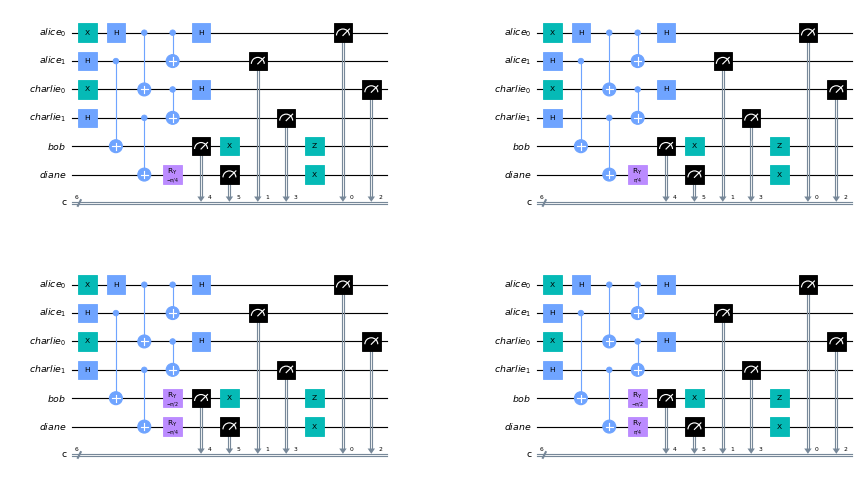

In [7]:
qc_all = []
for i in range(1,5):
    
    a = QuantumRegister(2, 'alice')
    c = QuantumRegister(2, 'charlie')
    b = QuantumRegister(1, 'bob')
    d = QuantumRegister(1, 'diane')
    m = ClassicalRegister(6, 'c')

    qc = QuantumCircuit(a,c,b,d,m)

    qc.x(0)
    qc.x(2)
    qc.h(0)
    qc.cx(0,2)

    qc.h(1)
    qc.cx(1,4)

    qc.h(3)
    qc.cx(3,5)

    qc.cx(0,1)
    qc.h(0)
    qc.measure([0,1],[0,1])
    qc.cx(2,3)
    qc.h(2)
    qc.measure([2,3],[2,3])
    
    if i == 1:
        qc.ry(-np.pi/4,5)
       
    if i ==2:
        qc.ry(np.pi/4,5)
      
    if i == 3:
        qc.ry(-np.pi/2,4)
        qc.ry(-np.pi/4,5)
        
    if i == 4:
        qc.ry(-np.pi/2,4)
        qc.ry(np.pi/4,5)
    qc.measure([4,5],[4,5])   
    qc_all.append(qc)
    
    qc.x(4)
    qc.z(4)
    qc.x(5)
  
print("""we add X and Z opertions to Bob and Diane's qubits to see if the 
final values change when Alice and Charlie measurements are the same.
Any combination of applying X's and Z's to Bob's and Diane's qubits
don't change S which means they have no net effect on their measurements
""")

def same_measurement(counts):
    counts_same = {}
    counts_list = list(counts.keys())
    for s in counts_list:
        if s[4] == s[2] and s[5] == s[3]:
            counts_same[s] = counts[s]
    return counts_same
def same_count(counts):
    counts_list = list(counts.keys())
    total_count = 0
    for s in counts_list:
        if s[0] == s[1]:
            total_count += counts.get(s,0)
    return total_count
def diff_count(counts):
    counts_list = list(counts.keys())
    total_count = 0
    for s in counts_list:
        if s[0] != s[1]:
            total_count += counts.get(s,0)
    return total_count

def min_cx(U, t=20):  #by default, tries 20 transpilations (doesn't take too long)
    U_all = [transpile(U, backend,optimization_level=3) for _ in range(t)]  #try t of them
    num_cx = np.array([Uc.count_ops().get('cx',0) for Uc in U_all])
    print(f'#cx gates ranges from {num_cx.min()} to {num_cx.max()} (using the minimum)')
    return U_all[num_cx.argmin()] #return one with minimum number of cX

simulator = True
if simulator:
    backend_sim = Aer.get_backend('qasm_simulator')
    job_sim = backend_sim.run(qc_all, shots=8192)
    result_sim = job_sim.result()
    counts = result_sim.get_counts()
else:
    best_qc_all = [min_cx(qc) for qc in qc_all]
    backend = provider.backend.backends(device_name)[0]
    tags = ['GHZ_7']
    transpiled_circuits = transpile(qc_all, backend)
    transpiled_circuits[-2].draw('mpl') 
    job = backend.run(transpiled_circuits, job_tags=tags, shots=8192)
    counts = job.result().get_counts()
expectation_values = []

same_m_counts = []
for i in range(len(counts)): 
    # print(counts[i])
    same_m_count = same_measurement(counts[i])
    same_m_counts.append(same_m_count)
    print(f'{i}: {same_m_count}')
    same_counts = same_count(same_m_count)
    different_counts = diff_count(same_m_count)

    total_counts = same_counts + different_counts
    if i == 3:
        total_counts = -1*total_counts
    
    expectation = (same_counts - different_counts) / total_counts
    expectation_values.append(expectation)

total_expectation = sum(expectation_values)
print("""Expectation Values for the Circuits using only the counts from the meausrments
where Alice and Charlie's measurments are the same""")
for i, exp_value in enumerate(expectation_values):
    print(f"Expectation Value for Circuit {i + 1}: {exp_value}")
print(f"Entanglement Witnes S: {total_expectation}")
print("""The S value is the same so we know that Bob's and Dianes state is 
the correct state that was teleported by Alice and Charlie""")



fig,ax = plt.subplots(2,2, figsize=(11,6))
for i in range(4): qc_all[i].draw('mpl', ax=ax.flatten()[i])